In [1]:
%pylab inline
from time import time
import seaborn as sns
from pandas import DataFrame
from pyspark.sql.types import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def build_df_table(df, table_name, s3_bucket, years, parquet=False):
    for year in years:
        if parquet:
            temp_df = sqlContext.read.parquet("s3a://{}/year={}".format(s3_bucket, year))
        else:
            temp_df = sqlContext.read.json("s3a://{}/{}".format(s3_bucket, year), df.schema)
            
        df = df.unionAll(temp_df)

    df.registerTempTable(table_name)
    
    return df

In [3]:
schema = StructType([
        StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("author_flair_text", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("removal_reason", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)])

years = [2007, 2008, 2009, 2010, 2011, 2012]
df_parquet = sqlContext.createDataFrame([], schema)
df_json = sqlContext.createDataFrame([], schema)

df_parquet = build_df_table(df_parquet, "comments_parquet", "reddit-comments-parquet", years, parquet=True)
df_json = build_df_table(df_json, "comments_json", "reddit-comments", years, parquet=False)

In [4]:
def query_1(table_name):
    """Standard Map Reduce with a Filter query"""
    
    result1 = sqlContext.sql("""
        SELECT   subreddit, 
                 COUNT(DISTINCT author) as author_cnt, 
                 COUNT(gilded) as gilded_cnt, 
                 COUNT(controversiality) as controversiality_cnt
        FROM     {}
        WHERE    author <> "[deleted]"
        GROUP BY subreddit
    """.format(table_name))
    start_time = time()
    result_cnt = result1.count()
    elapsed_time = time() - start_time
    print("[{}] Time elapsed (s): {}, # of records: {}".format(table_name, elapsed_time, result_cnt))
    
    return elapsed_time
    
parquet_time_1 = query_1("comments_parquet")
json_time_1 = query_1("comments_json")

[comments_parquet] Time elapsed (s): 47.30509305, # of records: 70990
[comments_json] Time elapsed (s): 190.449006081, # of records: 70990


In [5]:
def query_2(table_name):
    """Needle in a haystack query"""
    
    result1 = sqlContext.sql("""
        SELECT   subreddit, 
                 author, 
                 gilded, 
                 controversiality
        FROM     {}
        WHERE    author = "Eldilia"
        AND      gilded = 1
        ORDER BY created_utc ASC
        LIMIT 25
    """.format(table_name))
    start_time = time()
    result_cnt = result1.count()
    elapsed_time = time() - start_time
    print("[{}] Time elapsed (s): {}, # of records: {}".format(table_name, elapsed_time, result_cnt))
    
    return elapsed_time
    
parquet_time_2 = query_2("comments_parquet")
json_time_2 = query_2("comments_json")

[comments_parquet] Time elapsed (s): 5.72052693367, # of records: 10
[comments_json] Time elapsed (s): 163.238131046, # of records: 10


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=9.35. Returning /usr/share/matplotlib/mpl-data/fonts

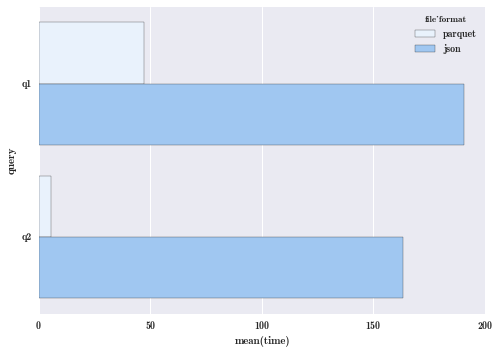

In [6]:
benchmark_dict = {"time": [parquet_time_1, parquet_time_2, json_time_1, json_time_2],
                  "file_format": ["parquet"]*2 + ["json"]*2,
                  "query": ["q1", "q2"]*2}
benchmark_df = DataFrame(benchmark_dict)

sns.set_color_codes("pastel")
sns.barplot(x="time", y="query", hue="file_format", data=benchmark_df, color="b")